In Deep learning, data augmentation techniques and transforms are essential to improve the quality and quantity of data used to train models. In the case of the CIFAR10 dataset, which consists of 60,000 color images of 32x32 pixels, these techniques are particularly important.

To augment the data, we use two techniques - Random Crop and Random Horizontal Flip. Random Crop selects a random subset of the original image, while Random Horizontal Flip flips an image horizontally with a certain probability. Both of these techniques help to introduce variations in the dataset, making the model more capable of recognizing similar images with different compositions.

After applying the data augmentation techniques, we use the To Tensor transform, which converts the images into PyTorch tensors and scales them by 255. This transformation is essential because PyTorch works with tensors, and scaling the images helps to normalize the pixel values.

Lastly, we apply the Normalize transform to adjust the mean and standard deviation of the image pixels, making the images more standardized. The values of the pixels become 0.0 and 1.0, respectively.

To ensure consistency and reproducibility, we download the CIFAR10 dataset in the root directory ./data and set PyTorch's random number generator to a seed value of 17. By doing this, we get the same validation set each time, which helps us to evaluate the model's performance accurately.

Overall, applying data augmentation techniques and transforms to the CIFAR10 dataset helps to improve the quality of the data and enhance the model's performance. These techniques can also be applied to other datasets, making it an essential part of machine learning workflows.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))  
        # check if the dataset exists in torchvision
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        # set number of workers available for multiprocessing
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        # add data augmentation transforms to the training set
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        # add ToTensor transform to the training and testing sets
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        # load training set to compute mean and standard deviation
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        # add Normalize transform to the training and testing sets
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        # create data loaders with the defined batch size, transformers and number of workers
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        # return the training and testing data loaders
        return load_train, load_test
    

# create a new instance of FetchDataset for the CIFAR10 dataset with batch size of 128
df = FetchDataset(dataset="CIFAR10", batch_size=128)
# add data augmentation transforms to the training set with size 32 and padding 4
df.dataAugmentation(size=32, padding=4)
# add normalizing transforms to the training and testing sets
df.addNormalizer()
# get the training and testing data loaders
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:02<00:00, 84303642.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Modified the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 

• Ci, the number of channels in the ith layer.
• Fi, the filter size in the ith layer
• Ki, the kernel size in the ith skip connection
• P, the pool size in the average pool layer

Using the following values for the Hyperparameters (design variables) in our architectures : 

    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]  
    P=4



In [ ]:
# Import necessary PyTorch modules
import torch.nn as nn
import torch.nn.functional as F

# Define the BasicBlock class, which is used to construct the layers in the ResNet architecture
class BasicBlock(nn.Module):

    # Initialize the BasicBlock class
    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Define the shortcut connection, which is used to add the output of the convolutional layers to the input
        self.shortcut = nn.Sequential()

        # If the stride is not 1 or the number of input planes is not equal to the number of output planes, 
        # define a convolutional layer and a batch normalization layer for the shortcut connection
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    # Define the forward pass for the BasicBlock class
    def forward(self, x):
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply the second convolutional layer and batch normalization
        out = self.bn2(self.conv2(out))

        # Add the shortcut connection to the output of the convolutional layers
        out += self.shortcut(x)

        # Apply the ReLU activation
        out = F.relu(out)

        return out

# Define the ResNet class, which is used to construct the ResNet architecture
class ResNet(nn.Module):

    # Initialize the ResNet class
    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
        super(ResNet, self).__init__()

        # Initialize the number of input planes
        self.in_planes = C[0]

        # Set the block to the BasicBlock class
        self.block = BasicBlock

        # Store the values of N, B, C, F, K, and P
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P

        # Initialize a container for the layers
        self.layers = []

        # Set the stride for each layer
        self.S = [2] * N
        self.S[0] = 1

        # Calculate the input dimension for the output linear layer
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

        # Define the first convolution layer with 3 input channels, C[0] output channels, F[0] kernel size,
        # stride of 1, padding of 1, and no bias
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        # Define a batch normalization layer with C[0] channels
        self.bn1 = nn.BatchNorm2d(C[0])
        
        # Define N residual blocks
        for i in range(N): 
          # Dynamically create variable names for each residual block using the exec() function
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            # Append the residual block to the layers ModuleList
            exec("self.layers.append(self.layer{})".format(i+1))
            # Define the final linear layer with input size of outLayerInSize and output size of num_classes
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Set stride for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride)) # Append each block to the layer with given arguments
            self.in_planes = planes  # Update the number of input planes for the next block
        return nn.Sequential(*layers)  # Return a sequential module containing all the blocks in the layer

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply all the blocks in the layer
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P) # Apply average pooling with kernel size self.P
        out = out.view(out.size(0), -1)  # Flatten the output tensor
        out = self.linear(out)  # Apply the fully connected linear layer
        return out # Return the final output

def resnet_model():
# Define the parameters for the ResNet architecture
    B=[3,3,2,3]  # number of blocks in each layer
    C=[64,128,128,256]  # number of output channels in each layer
    F=[3,3,3,3]  # kernel size for each layer
    K=[1,1,1,1] # skip kernel size for each layer
    P=4       # average pooling kernel size
    N=len(B)  # number of layers in the network
# Return a new ResNet model with the defined parameters
    return ResNet(N, B, C, F, K, P)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = resnet_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


We run our model for 300 epochs, to find out the best possible accuracy. The accuracy becomes near about constant after it. We define our:

learning rate, weightDecay, type of optimizer to be used (we tried with Adam, Adagrad, AdaDelta), with Adadelta giving out the best accuracy.

The scheduler set the learning rate of each parameter group using a cosine annealing schedule


###**ADAM Optimizer**

In [ ]:
EPOCHS=300
globalBestAccuracy = 0.0
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

loss_function = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Model Training and Testing.
Here we are training our model over 300 epochs and trying to find out the best accuracy our model provides for the CIFAR dataset.

In [ ]:
def train(model,loader, optimizer): # Define the function to train the model and return the updated model and optimizer
    model.train()                   # Set the model to train mode
    optimizer.zero_grad()            # Clear the gradients of the optimizer
    return model, optimizer         # Return the updated model and optimizer

def test(model,loader):          # Define the function to evaluate the model on the test set
    return model.eval()          # Set the model to evaluation mode

def getLoss(loader,model,optimizer):        # Define the function to calculate the loss and accuracy for a given loader and model
    running_loss = 0.0                      # Initialize the running loss and correct count
    running_correct = 0
    for images, labels in loader:            # Iterate through the loader
        images = images.to(device)           # Move the images and labels to the device
        labels = labels.to(device)
        output = model(images)               # Forward pass
        loss = loss_function(output, labels) # Calculate the loss
        predicted_labels = torch.argmax(output, dim=1)  # Calculate the predicted labels
        running_loss += loss.item()    # Update the running loss and correct count
        running_correct += torch.sum(predicted_labels == labels).float().item()
        if phase == "train":           # If the phase is "train", backpropagate the loss and update the optimizer
            loss.backward()
            optimizer.step()
    return running_loss,running_correct


In [ ]:
for i in tqdm(range(EPOCHS)):        # Iterate through the epochs
    for phase in ['train', 'test']:   # Iterate through the phases (train and test)
        if phase == "train":          # If the phase is "train", set the loader and call the train function
            loader = trainLoader
            model,optimzier= train(model,loader,optimizer)
        else:                      # If the phase is "test", set the loader and call the test function
            loader = testLoader
            model=test(model,loader)
        running_loss,running_correct = getLoss(loader,model,optimizer)
        epoch_loss = running_loss/len(loader.dataset)      # Calculate the epoch loss and accuracy
        epoch_acc = running_correct/len(loader.dataset)
        if phase == "train":          # If the phase is "train", update the scheduler and append the results to the train lists
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        else:                         # If the phase is "test", append the results to the test lists and update the global best accuracy
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc) 

        torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy,
                    }, '/content/gdrive/MyDrive/model2.pt')

    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\              # Print the results for the current epoch
          %(train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))

  0%|          | 1/300 [00:53<4:24:38, 53.11s/it]

Training Loss : 2.5115449896240234, Testing Loss : 2.7181516757965087, Training Accuracy : 0.10006, Testing Accuracy : 0.1


  1%|          | 2/300 [01:46<4:25:03, 53.37s/it]

Training Loss : 2.574282617492676, Testing Loss : 2.5344732425689696, Training Accuracy : 0.10004, Testing Accuracy : 0.1


  1%|          | 3/300 [02:37<4:19:24, 52.40s/it]

Training Loss : 2.496542536315918, Testing Loss : 2.584727862548828, Training Accuracy : 0.09922, Testing Accuracy : 0.1


  1%|▏         | 4/300 [03:31<4:20:27, 52.79s/it]

Training Loss : 2.5271830899047854, Testing Loss : 2.5338068775177, Training Accuracy : 0.0983, Testing Accuracy : 0.0997


  2%|▏         | 5/300 [04:23<4:18:05, 52.49s/it]

Training Loss : 2.4802432315063476, Testing Loss : 2.4508478267669678, Training Accuracy : 0.10316, Testing Accuracy : 0.0997


  2%|▏         | 6/300 [05:16<4:17:41, 52.59s/it]

Training Loss : 2.437269440307617, Testing Loss : 2.4632112449645995, Training Accuracy : 0.09748, Testing Accuracy : 0.1


  2%|▏         | 7/300 [06:09<4:18:30, 52.94s/it]

Training Loss : 2.4234398226928713, Testing Loss : 2.4179781257629394, Training Accuracy : 0.10134, Testing Accuracy : 0.1


  3%|▎         | 8/300 [07:00<4:14:57, 52.39s/it]

Training Loss : 2.416207106323242, Testing Loss : 2.428897608566284, Training Accuracy : 0.10094, Testing Accuracy : 0.1


  3%|▎         | 9/300 [07:54<4:15:44, 52.73s/it]

Training Loss : 2.4103893798828127, Testing Loss : 2.4908620750427244, Training Accuracy : 0.09994, Testing Accuracy : 0.0996


  3%|▎         | 10/300 [08:46<4:14:12, 52.60s/it]

Training Loss : 2.467157725830078, Testing Loss : 2.5852174240112307, Training Accuracy : 0.09962, Testing Accuracy : 0.0997


  4%|▎         | 11/300 [09:39<4:12:58, 52.52s/it]

Training Loss : 2.5276749725341796, Testing Loss : 2.4344369106292723, Training Accuracy : 0.09926, Testing Accuracy : 0.1


  4%|▍         | 12/300 [10:32<4:14:00, 52.92s/it]

Training Loss : 2.426012887573242, Testing Loss : 2.395417000198364, Training Accuracy : 0.09908, Testing Accuracy : 0.1


  4%|▍         | 13/300 [11:24<4:11:37, 52.60s/it]

Training Loss : 2.3835993762207033, Testing Loss : 2.4034313106536866, Training Accuracy : 0.09962, Testing Accuracy : 0.1004


  5%|▍         | 14/300 [12:18<4:13:07, 53.10s/it]

Training Loss : 2.391955552368164, Testing Loss : 2.773055665588379, Training Accuracy : 0.1001, Testing Accuracy : 0.0983


  5%|▌         | 15/300 [13:12<4:13:21, 53.34s/it]

Training Loss : 2.401213876953125, Testing Loss : 4.407480944061279, Training Accuracy : 0.09992, Testing Accuracy : 0.124


  5%|▌         | 16/300 [14:04<4:10:18, 52.88s/it]

Training Loss : 2.4815620385742188, Testing Loss : 2.6158848541259765, Training Accuracy : 0.10016, Testing Accuracy : 0.1082


  6%|▌         | 17/300 [14:58<4:10:14, 53.05s/it]

Training Loss : 2.495260171508789, Testing Loss : 2.776174662399292, Training Accuracy : 0.10358, Testing Accuracy : 0.1196


  6%|▌         | 18/300 [15:50<4:08:12, 52.81s/it]

Training Loss : 2.512600622558594, Testing Loss : 2.5927466426849364, Training Accuracy : 0.09986, Testing Accuracy : 0.1


  6%|▋         | 19/300 [16:42<4:06:58, 52.73s/it]

Training Loss : 2.5199392248535157, Testing Loss : 2.4116333641052248, Training Accuracy : 0.09938, Testing Accuracy : 0.1


  7%|▋         | 20/300 [17:36<4:06:39, 52.86s/it]

Training Loss : 2.4153979922485354, Testing Loss : 2.4259653896331788, Training Accuracy : 0.1002, Testing Accuracy : 0.1


  7%|▋         | 21/300 [18:27<4:03:48, 52.43s/it]

Training Loss : 2.4123485415649415, Testing Loss : 2.4690521076202394, Training Accuracy : 0.10008, Testing Accuracy : 0.1


  7%|▋         | 22/300 [19:20<4:03:48, 52.62s/it]

Training Loss : 2.4331410330200196, Testing Loss : 2.451615244293213, Training Accuracy : 0.10072, Testing Accuracy : 0.1


  8%|▊         | 23/300 [20:12<4:02:08, 52.45s/it]

Training Loss : 2.4389807064819338, Testing Loss : 2.5032477474212644, Training Accuracy : 0.0987, Testing Accuracy : 0.1


  8%|▊         | 24/300 [21:04<4:00:40, 52.32s/it]

Training Loss : 2.4523380505371093, Testing Loss : 2.537466466140747, Training Accuracy : 0.10076, Testing Accuracy : 0.1


  8%|▊         | 25/300 [21:58<4:01:29, 52.69s/it]

Training Loss : 2.4933965032958985, Testing Loss : 2.5013695251464845, Training Accuracy : 0.10058, Testing Accuracy : 0.1


  9%|▊         | 26/300 [22:49<3:58:40, 52.27s/it]

Training Loss : 2.4555527749633788, Testing Loss : 4.62404630241394, Training Accuracy : 0.09784, Testing Accuracy : 0.0891


  9%|▉         | 27/300 [23:42<3:58:25, 52.40s/it]

Training Loss : 2.5039449996948244, Testing Loss : 2.5164929187774656, Training Accuracy : 0.1016, Testing Accuracy : 0.1


  9%|▉         | 28/300 [24:35<3:58:34, 52.63s/it]

Training Loss : 2.486978818664551, Testing Loss : 2.5562563613891602, Training Accuracy : 0.10014, Testing Accuracy : 0.1


 10%|▉         | 29/300 [25:27<3:56:24, 52.34s/it]

Training Loss : 2.4923680657958984, Testing Loss : 2.4418339614868163, Training Accuracy : 0.0996, Testing Accuracy : 0.1


 10%|█         | 30/300 [26:20<3:57:17, 52.73s/it]

Training Loss : 2.421377738647461, Testing Loss : 2.4043018962860105, Training Accuracy : 0.10108, Testing Accuracy : 0.1


 10%|█         | 31/300 [27:12<3:54:56, 52.41s/it]

Training Loss : 2.3733505087280276, Testing Loss : 8.938605102539062, Training Accuracy : 0.09874, Testing Accuracy : 0.1016


 11%|█         | 32/300 [28:05<3:54:38, 52.53s/it]

Training Loss : 2.418440899658203, Testing Loss : 2.4358123878479003, Training Accuracy : 0.09964, Testing Accuracy : 0.1


 11%|█         | 33/300 [28:57<3:53:40, 52.51s/it]

Training Loss : 2.3963614178466797, Testing Loss : 2.4238613414764405, Training Accuracy : 0.10086, Testing Accuracy : 0.1


 11%|█▏        | 34/300 [29:49<3:51:53, 52.31s/it]

Training Loss : 2.418448133239746, Testing Loss : 2.4874233612060546, Training Accuracy : 0.10016, Testing Accuracy : 0.1


 12%|█▏        | 35/300 [30:42<3:52:25, 52.62s/it]

Training Loss : 2.4557222631835938, Testing Loss : 2.4880004600524903, Training Accuracy : 0.1012, Testing Accuracy : 0.1


 12%|█▏        | 36/300 [31:34<3:50:10, 52.31s/it]

Training Loss : 2.44314602142334, Testing Loss : 2.584379322814941, Training Accuracy : 0.09876, Testing Accuracy : 0.1


 12%|█▏        | 37/300 [32:27<3:50:57, 52.69s/it]

Training Loss : 2.4535588537597657, Testing Loss : 2.614582341384888, Training Accuracy : 0.1007, Testing Accuracy : 0.1


 13%|█▎        | 38/300 [33:19<3:48:59, 52.44s/it]

Training Loss : 2.4390418243408205, Testing Loss : 2.5224050338745116, Training Accuracy : 0.09692, Testing Accuracy : 0.1


 13%|█▎        | 39/300 [34:11<3:46:45, 52.13s/it]

Training Loss : 2.4626368200683593, Testing Loss : 2.5577548633575438, Training Accuracy : 0.0992, Testing Accuracy : 0.1


 13%|█▎        | 40/300 [35:04<3:47:10, 52.43s/it]

Training Loss : 2.4803876013183594, Testing Loss : 2.4553739486694335, Training Accuracy : 0.09994, Testing Accuracy : 0.1


 14%|█▎        | 41/300 [35:55<3:45:11, 52.17s/it]

Training Loss : 2.4406739950561525, Testing Loss : 2.4890185565948486, Training Accuracy : 0.1015, Testing Accuracy : 0.1153


 14%|█▍        | 42/300 [36:49<3:45:40, 52.48s/it]

Training Loss : 2.4514818991088867, Testing Loss : 2.5792465423583986, Training Accuracy : 0.10024, Testing Accuracy : 0.1


 14%|█▍        | 43/300 [37:41<3:44:26, 52.40s/it]

Training Loss : 2.5202700131225586, Testing Loss : 2.5566980110168456, Training Accuracy : 0.10092, Testing Accuracy : 0.1


 15%|█▍        | 44/300 [38:33<3:43:17, 52.33s/it]

Training Loss : 2.4646627478027345, Testing Loss : 2.6484891998291014, Training Accuracy : 0.09998, Testing Accuracy : 0.1


 15%|█▌        | 45/300 [39:26<3:43:44, 52.65s/it]

Training Loss : 2.532027163696289, Testing Loss : 2.4443966625213625, Training Accuracy : 0.10192, Testing Accuracy : 0.1


 15%|█▌        | 46/300 [40:18<3:42:02, 52.45s/it]

Training Loss : 2.4464820373535154, Testing Loss : 2.46876011428833, Training Accuracy : 0.10002, Testing Accuracy : 0.1


 16%|█▌        | 47/300 [41:11<3:41:42, 52.58s/it]

Training Loss : 2.4261504486083982, Testing Loss : 2.5633094806671144, Training Accuracy : 0.0988, Testing Accuracy : 0.0883


 16%|█▌        | 48/300 [42:04<3:41:02, 52.63s/it]

Training Loss : 2.4086627923583985, Testing Loss : 3.826700525665283, Training Accuracy : 0.10354, Testing Accuracy : 0.1


 16%|█▋        | 49/300 [42:57<3:40:18, 52.66s/it]

Training Loss : 3.0585814086914063, Testing Loss : 3.9224335144042968, Training Accuracy : 0.10064, Testing Accuracy : 0.1


 17%|█▋        | 50/300 [43:51<3:40:49, 53.00s/it]

Training Loss : 2.9318542388916016, Testing Loss : 2.538388332748413, Training Accuracy : 0.10006, Testing Accuracy : 0.1


 17%|█▋        | 51/300 [44:43<3:38:55, 52.75s/it]

Training Loss : 2.601323240966797, Testing Loss : 12.037515063476562, Training Accuracy : 0.09834, Testing Accuracy : 0.1


 17%|█▋        | 52/300 [45:36<3:38:32, 52.87s/it]

Training Loss : 3.4634024307250977, Testing Loss : 2.866824580383301, Training Accuracy : 0.10102, Testing Accuracy : 0.1


 18%|█▊        | 53/300 [46:30<3:39:00, 53.20s/it]

Training Loss : 2.797570200805664, Testing Loss : 3.390602599334717, Training Accuracy : 0.09996, Testing Accuracy : 0.1


 18%|█▊        | 54/300 [47:22<3:36:48, 52.88s/it]

Training Loss : 2.5428135009765627, Testing Loss : 2.668299655532837, Training Accuracy : 0.10168, Testing Accuracy : 0.1


 18%|█▊        | 55/300 [48:15<3:35:49, 52.86s/it]

Training Loss : 2.471526468811035, Testing Loss : 2.4145833255767823, Training Accuracy : 0.1039, Testing Accuracy : 0.1


 19%|█▊        | 56/300 [49:09<3:36:08, 53.15s/it]

Training Loss : 2.941873931274414, Testing Loss : 3.166718679046631, Training Accuracy : 0.09912, Testing Accuracy : 0.1


 19%|█▉        | 57/300 [50:00<3:33:37, 52.75s/it]

Training Loss : 2.7139820022583008, Testing Loss : 3.402030937957764, Training Accuracy : 0.10112, Testing Accuracy : 0.1


 19%|█▉        | 58/300 [50:54<3:33:35, 52.96s/it]

Training Loss : 2.534146623535156, Testing Loss : 2.4577402130126953, Training Accuracy : 0.10012, Testing Accuracy : 0.1


 20%|█▉        | 59/300 [51:48<3:33:50, 53.24s/it]

Training Loss : 2.412534053955078, Testing Loss : 2.703105657196045, Training Accuracy : 0.09672, Testing Accuracy : 0.1


 20%|██        | 60/300 [52:40<3:31:27, 52.86s/it]

Training Loss : 2.393736779785156, Testing Loss : 2.418498965835571, Training Accuracy : 0.09788, Testing Accuracy : 0.1


 20%|██        | 61/300 [53:33<3:31:06, 53.00s/it]

Training Loss : 2.4168347338867187, Testing Loss : 2.7194945026397703, Training Accuracy : 0.09952, Testing Accuracy : 0.1002


 21%|██        | 62/300 [54:26<3:29:53, 52.92s/it]

Training Loss : 2.6533205233764647, Testing Loss : 2.6422097717285156, Training Accuracy : 0.09898, Testing Accuracy : 0.1


 21%|██        | 63/300 [55:19<3:29:11, 52.96s/it]

Training Loss : 2.5853466647338865, Testing Loss : 2.509756428527832, Training Accuracy : 0.1015, Testing Accuracy : 0.1


 21%|██▏       | 64/300 [56:13<3:29:34, 53.28s/it]

Training Loss : 2.4907671810913086, Testing Loss : 2.645417866897583, Training Accuracy : 0.0995, Testing Accuracy : 0.1


 22%|██▏       | 65/300 [57:04<3:26:21, 52.69s/it]

Training Loss : 2.535134960632324, Testing Loss : 2.572698163986206, Training Accuracy : 0.09888, Testing Accuracy : 0.1


 22%|██▏       | 66/300 [57:57<3:25:58, 52.82s/it]

Training Loss : 2.475155044555664, Testing Loss : 2.601090798187256, Training Accuracy : 0.09982, Testing Accuracy : 0.1


 22%|██▏       | 67/300 [58:52<3:27:00, 53.31s/it]

Training Loss : 2.4658202795410156, Testing Loss : 233.64074501953124, Training Accuracy : 0.1011, Testing Accuracy : 0.1


 23%|██▎       | 68/300 [59:44<3:24:25, 52.87s/it]

Training Loss : 2.3866404373168946, Testing Loss : 2.39444072303772, Training Accuracy : 0.10026, Testing Accuracy : 0.1041


 23%|██▎       | 69/300 [1:00:38<3:24:54, 53.22s/it]

Training Loss : 2.352609626159668, Testing Loss : 2.304650984954834, Training Accuracy : 0.10048, Testing Accuracy : 0.1207


 23%|██▎       | 70/300 [1:01:31<3:24:24, 53.32s/it]

Training Loss : 2.3225936138916015, Testing Loss : 2.3315374431610105, Training Accuracy : 0.10428, Testing Accuracy : 0.1


 24%|██▎       | 71/300 [1:02:23<3:22:11, 52.98s/it]

Training Loss : 2.337401962890625, Testing Loss : 2.352132459640503, Training Accuracy : 0.09988, Testing Accuracy : 0.1


 24%|██▍       | 72/300 [1:03:18<3:22:52, 53.39s/it]

Training Loss : 2.374796971435547, Testing Loss : 3.283861869049072, Training Accuracy : 0.09832, Testing Accuracy : 0.1


 24%|██▍       | 73/300 [1:04:09<3:19:51, 52.82s/it]

Training Loss : 2.394511413574219, Testing Loss : 2.470474102783203, Training Accuracy : 0.09952, Testing Accuracy : 0.1


 25%|██▍       | 74/300 [1:05:02<3:19:15, 52.90s/it]

Training Loss : 2.4431714935302735, Testing Loss : 2.618236846923828, Training Accuracy : 0.10038, Testing Accuracy : 0.1


 25%|██▌       | 75/300 [1:05:56<3:19:42, 53.26s/it]

Training Loss : 2.5083107858276366, Testing Loss : 2.8793356655120848, Training Accuracy : 0.09994, Testing Accuracy : 0.1


 25%|██▌       | 76/300 [1:06:48<3:17:26, 52.89s/it]

Training Loss : 2.3973416897583006, Testing Loss : 2.518698384857178, Training Accuracy : 0.0989, Testing Accuracy : 0.0918


 26%|██▌       | 77/300 [1:07:42<3:17:16, 53.08s/it]

Training Loss : 2.424843219909668, Testing Loss : 2.4492478458404543, Training Accuracy : 0.0992, Testing Accuracy : 0.101


 26%|██▌       | 78/300 [1:08:36<3:17:06, 53.27s/it]

Training Loss : 2.399642203979492, Testing Loss : 2.467860721206665, Training Accuracy : 0.102, Testing Accuracy : 0.1


 26%|██▋       | 79/300 [1:09:28<3:14:57, 52.93s/it]

Training Loss : 2.412879982910156, Testing Loss : 14.958598138427734, Training Accuracy : 0.10046, Testing Accuracy : 0.1


 27%|██▋       | 80/300 [1:10:22<3:15:09, 53.23s/it]

Training Loss : 2.4609917764282225, Testing Loss : 2.4251259674072267, Training Accuracy : 0.10074, Testing Accuracy : 0.1


 27%|██▋       | 81/300 [1:11:14<3:13:26, 53.00s/it]

Training Loss : 2.4074148751831053, Testing Loss : 2.418015592956543, Training Accuracy : 0.1006, Testing Accuracy : 0.1


 27%|██▋       | 82/300 [1:12:07<3:12:02, 52.86s/it]

Training Loss : 2.3918399368286134, Testing Loss : 24.449442727661133, Training Accuracy : 0.10146, Testing Accuracy : 0.1


 28%|██▊       | 83/300 [1:13:01<3:12:23, 53.20s/it]

Training Loss : 2.4250632525634765, Testing Loss : 2.4437657638549806, Training Accuracy : 0.09914, Testing Accuracy : 0.1


 28%|██▊       | 84/300 [1:13:52<3:09:52, 52.75s/it]

Training Loss : 2.405951680603027, Testing Loss : 2.5159466217041015, Training Accuracy : 0.09776, Testing Accuracy : 0.1


 28%|██▊       | 85/300 [1:14:46<3:09:45, 52.95s/it]

Training Loss : 2.4775459353637697, Testing Loss : 3.0403247943878173, Training Accuracy : 0.09978, Testing Accuracy : 0.1136


 29%|██▊       | 86/300 [1:15:40<3:09:47, 53.21s/it]

Training Loss : 2.5711541708374024, Testing Loss : 5.3789356941223145, Training Accuracy : 0.09984, Testing Accuracy : 0.1


 29%|██▉       | 87/300 [1:16:32<3:07:51, 52.92s/it]

Training Loss : 2.698598035583496, Testing Loss : 2.633738883590698, Training Accuracy : 0.1001, Testing Accuracy : 0.1


 29%|██▉       | 88/300 [1:17:26<3:07:46, 53.14s/it]

Training Loss : 2.6604317669677733, Testing Loss : 2.675916171646118, Training Accuracy : 0.1009, Testing Accuracy : 0.1


 30%|██▉       | 89/300 [1:18:20<3:07:48, 53.41s/it]

Training Loss : 2.4972077587890626, Testing Loss : 2.4189207302093507, Training Accuracy : 0.10258, Testing Accuracy : 0.1


 30%|███       | 90/300 [1:19:11<3:05:21, 52.96s/it]

Training Loss : 2.3779715124511718, Testing Loss : 2.4133324962615967, Training Accuracy : 0.10144, Testing Accuracy : 0.1


 30%|███       | 91/300 [1:20:05<3:05:24, 53.23s/it]

Training Loss : 2.392040937805176, Testing Loss : 2.366600522994995, Training Accuracy : 0.09962, Testing Accuracy : 0.1


 31%|███       | 92/300 [1:20:58<3:03:43, 53.00s/it]

Training Loss : 2.3470897009277345, Testing Loss : 2.379064978790283, Training Accuracy : 0.09898, Testing Accuracy : 0.1


 31%|███       | 93/300 [1:21:50<3:02:25, 52.87s/it]

Training Loss : 2.365845278015137, Testing Loss : 2.4215122104644777, Training Accuracy : 0.10122, Testing Accuracy : 0.1


 31%|███▏      | 94/300 [1:22:44<3:02:14, 53.08s/it]

Training Loss : 2.3779531176757813, Testing Loss : 2.4444335666656496, Training Accuracy : 0.1012, Testing Accuracy : 0.1


 32%|███▏      | 95/300 [1:23:36<3:00:11, 52.74s/it]

Training Loss : 2.411189477233887, Testing Loss : 3.519577864456177, Training Accuracy : 0.09994, Testing Accuracy : 0.1147


 32%|███▏      | 96/300 [1:24:29<2:59:44, 52.86s/it]

Training Loss : 2.4308928796386717, Testing Loss : 2.5017570560455322, Training Accuracy : 0.09818, Testing Accuracy : 0.1


 32%|███▏      | 97/300 [1:25:22<2:59:07, 52.94s/it]

Training Loss : 2.4337406884765627, Testing Loss : 3.957923553085327, Training Accuracy : 0.1016, Testing Accuracy : 0.1


 33%|███▎      | 98/300 [1:26:14<2:57:16, 52.66s/it]

Training Loss : 2.376677502746582, Testing Loss : 11892.8358671875, Training Accuracy : 0.09942, Testing Accuracy : 0.1


 33%|███▎      | 99/300 [1:27:08<2:57:37, 53.02s/it]

Training Loss : 2.3703003942871095, Testing Loss : 2.356941077423096, Training Accuracy : 0.09954, Testing Accuracy : 0.0975


 33%|███▎      | 100/300 [1:28:00<2:55:38, 52.69s/it]

Training Loss : 2.331232639465332, Testing Loss : 2.3535767890930175, Training Accuracy : 0.10104, Testing Accuracy : 0.1


 34%|███▎      | 101/300 [1:28:52<2:54:26, 52.59s/it]

Training Loss : 2.351628502197266, Testing Loss : 132.9661901123047, Training Accuracy : 0.0995, Testing Accuracy : 0.1


 34%|███▍      | 102/300 [1:29:46<2:54:46, 52.96s/it]

Training Loss : 2.367627735900879, Testing Loss : 5885.05275078125, Training Accuracy : 0.09996, Testing Accuracy : 0.1


 34%|███▍      | 103/300 [1:30:38<2:52:51, 52.65s/it]

Training Loss : 2.4461371295166017, Testing Loss : 2.8123597946166994, Training Accuracy : 0.10008, Testing Accuracy : 0.1033


 35%|███▍      | 104/300 [1:31:31<2:52:35, 52.84s/it]

Training Loss : 2.41666699798584, Testing Loss : 2.4406885486602783, Training Accuracy : 0.10038, Testing Accuracy : 0.1


 35%|███▌      | 105/300 [1:32:24<2:51:37, 52.81s/it]

Training Loss : 2.397435969543457, Testing Loss : 2.4699720066070556, Training Accuracy : 0.10148, Testing Accuracy : 0.1


 35%|███▌      | 106/300 [1:33:16<2:50:20, 52.68s/it]

Training Loss : 2.425652016296387, Testing Loss : 2.580156976318359, Training Accuracy : 0.09876, Testing Accuracy : 0.1


 36%|███▌      | 107/300 [1:34:11<2:51:03, 53.18s/it]

Training Loss : 2.3471031744384767, Testing Loss : 2.35615125541687, Training Accuracy : 0.09924, Testing Accuracy : 0.1


 36%|███▌      | 108/300 [1:35:03<2:49:07, 52.85s/it]

Training Loss : 2.322478641052246, Testing Loss : 2.3228411350250244, Training Accuracy : 0.1008, Testing Accuracy : 0.1


 36%|███▋      | 109/300 [1:35:55<2:47:40, 52.68s/it]

Training Loss : 2.3230813928222656, Testing Loss : 2.338385977554321, Training Accuracy : 0.09922, Testing Accuracy : 0.1


 37%|███▋      | 110/300 [1:36:49<2:48:06, 53.09s/it]

Training Loss : 2.335468029174805, Testing Loss : 2.341616895675659, Training Accuracy : 0.09802, Testing Accuracy : 0.1


 37%|███▋      | 111/300 [1:37:41<2:46:08, 52.74s/it]

Training Loss : 2.364204750671387, Testing Loss : 2.4034652751922607, Training Accuracy : 0.09926, Testing Accuracy : 0.1


 37%|███▋      | 112/300 [1:38:34<2:45:21, 52.78s/it]

Training Loss : 2.3875223733520508, Testing Loss : 2.403711038208008, Training Accuracy : 0.0998, Testing Accuracy : 0.1


 38%|███▊      | 113/300 [1:39:28<2:45:21, 53.06s/it]

Training Loss : 2.4119923736572266, Testing Loss : 2.350449239730835, Training Accuracy : 0.0996, Testing Accuracy : 0.1


 38%|███▊      | 114/300 [1:40:20<2:43:29, 52.74s/it]

Training Loss : 2.3442783615112304, Testing Loss : 2.324639318847656, Training Accuracy : 0.10062, Testing Accuracy : 0.1


 38%|███▊      | 115/300 [1:41:14<2:43:56, 53.17s/it]

Training Loss : 2.324689014892578, Testing Loss : 284.86442451171877, Training Accuracy : 0.1051, Testing Accuracy : 0.101


 39%|███▊      | 116/300 [1:42:08<2:43:32, 53.33s/it]

Training Loss : 2.3240545123291017, Testing Loss : 2.6654057037353516, Training Accuracy : 0.13086, Testing Accuracy : 0.1494


 39%|███▉      | 117/300 [1:43:00<2:42:16, 53.20s/it]

Training Loss : 2.34308642578125, Testing Loss : 2.6847760540008543, Training Accuracy : 0.13926, Testing Accuracy : 0.1451


 39%|███▉      | 118/300 [1:43:55<2:42:38, 53.62s/it]

Training Loss : 2.371742309875488, Testing Loss : 2.415783583831787, Training Accuracy : 0.13864, Testing Accuracy : 0.142


 40%|███▉      | 119/300 [1:44:50<2:42:34, 53.89s/it]

Training Loss : 2.330822897338867, Testing Loss : 2.5095852920532224, Training Accuracy : 0.15056, Testing Accuracy : 0.1305


 40%|████      | 120/300 [1:45:42<2:40:26, 53.48s/it]

Training Loss : 2.318798815612793, Testing Loss : 2.2121334720611574, Training Accuracy : 0.1358, Testing Accuracy : 0.1728


 40%|████      | 121/300 [1:46:36<2:39:44, 53.54s/it]

Training Loss : 2.1713834365844726, Testing Loss : 2.1047658332824706, Training Accuracy : 0.17238, Testing Accuracy : 0.1763


 41%|████      | 122/300 [1:47:30<2:39:17, 53.69s/it]

Training Loss : 2.10720159576416, Testing Loss : 2.2108245906829835, Training Accuracy : 0.18036, Testing Accuracy : 0.1683


 41%|████      | 123/300 [1:48:22<2:37:26, 53.37s/it]

Training Loss : 2.1758946801757815, Testing Loss : 2.9983952293395997, Training Accuracy : 0.1761, Testing Accuracy : 0.1585


 41%|████▏     | 124/300 [1:49:17<2:37:09, 53.58s/it]

Training Loss : 2.4502170782470705, Testing Loss : 2.596022226333618, Training Accuracy : 0.15332, Testing Accuracy : 0.0992


 42%|████▏     | 125/300 [1:50:10<2:36:16, 53.58s/it]

Training Loss : 2.4023988446044924, Testing Loss : 2.4957943264007567, Training Accuracy : 0.11608, Testing Accuracy : 0.1592


 42%|████▏     | 126/300 [1:51:02<2:34:09, 53.16s/it]

Training Loss : 2.2245573986816405, Testing Loss : 2.4763975994110106, Training Accuracy : 0.15636, Testing Accuracy : 0.1594


 42%|████▏     | 127/300 [1:51:56<2:34:03, 53.43s/it]

Training Loss : 2.1511633096313476, Testing Loss : 2.170814978790283, Training Accuracy : 0.17506, Testing Accuracy : 0.1649


 43%|████▎     | 128/300 [1:52:49<2:32:43, 53.27s/it]

Training Loss : 2.013557343444824, Testing Loss : 2.1073438388824464, Training Accuracy : 0.18294, Testing Accuracy : 0.1761


 43%|████▎     | 129/300 [1:53:42<2:31:39, 53.21s/it]

Training Loss : 2.0005340072631834, Testing Loss : 2.314467876434326, Training Accuracy : 0.18836, Testing Accuracy : 0.1642


 43%|████▎     | 130/300 [1:54:37<2:31:40, 53.53s/it]

Training Loss : 2.1371821701049805, Testing Loss : 2.0807184745788576, Training Accuracy : 0.18586, Testing Accuracy : 0.1755


 44%|████▎     | 131/300 [1:55:29<2:29:49, 53.19s/it]

Training Loss : 2.042939606628418, Testing Loss : 2.221289700317383, Training Accuracy : 0.1863, Testing Accuracy : 0.1504


 44%|████▍     | 132/300 [1:56:22<2:28:53, 53.18s/it]

Training Loss : 2.1536877072143557, Testing Loss : 2.593900450897217, Training Accuracy : 0.17294, Testing Accuracy : 0.1567


 44%|████▍     | 133/300 [1:57:16<2:28:52, 53.49s/it]

Training Loss : 2.11001259765625, Testing Loss : 2.519721260070801, Training Accuracy : 0.1765, Testing Accuracy : 0.1793


 45%|████▍     | 134/300 [1:58:09<2:27:07, 53.18s/it]

Training Loss : 2.1331791189575195, Testing Loss : 2.6992616500854494, Training Accuracy : 0.18122, Testing Accuracy : 0.1911


 45%|████▌     | 135/300 [1:59:02<2:26:36, 53.31s/it]

Training Loss : 2.3035162142944334, Testing Loss : 2.266026982498169, Training Accuracy : 0.17622, Testing Accuracy : 0.1752


 45%|████▌     | 136/300 [1:59:57<2:26:33, 53.62s/it]

Training Loss : 2.144622405090332, Testing Loss : 2.283102807235718, Training Accuracy : 0.18208, Testing Accuracy : 0.1643


 46%|████▌     | 137/300 [2:00:49<2:24:26, 53.17s/it]

Training Loss : 2.3594637048339844, Testing Loss : 2.4017691513061523, Training Accuracy : 0.17318, Testing Accuracy : 0.1902


 46%|████▌     | 138/300 [2:01:43<2:24:01, 53.34s/it]

Training Loss : 2.235639887084961, Testing Loss : 2.2078870906829833, Training Accuracy : 0.1816, Testing Accuracy : 0.1857


 46%|████▋     | 139/300 [2:02:37<2:24:03, 53.69s/it]

Training Loss : 2.041650511779785, Testing Loss : 1.9896759246826172, Training Accuracy : 0.1932, Testing Accuracy : 0.1796


 47%|████▋     | 140/300 [2:03:30<2:22:13, 53.34s/it]

Training Loss : 2.0009723501586913, Testing Loss : 1.9611277145385742, Training Accuracy : 0.1914, Testing Accuracy : 0.2046


 47%|████▋     | 141/300 [2:04:24<2:21:46, 53.50s/it]

Training Loss : 1.9684139556884765, Testing Loss : 2.1243244564056396, Training Accuracy : 0.19824, Testing Accuracy : 0.2346


 47%|████▋     | 142/300 [2:05:18<2:21:20, 53.68s/it]

Training Loss : 1.934263358154297, Testing Loss : 24.50160559387207, Training Accuracy : 0.2054, Testing Accuracy : 0.1248


 48%|████▊     | 143/300 [2:06:10<2:19:18, 53.24s/it]

Training Loss : 1.8680521310424805, Testing Loss : 2.015306713104248, Training Accuracy : 0.22544, Testing Accuracy : 0.2082


 48%|████▊     | 144/300 [2:07:04<2:18:50, 53.40s/it]

Training Loss : 1.9822244503784179, Testing Loss : 1.9628627227783204, Training Accuracy : 0.20658, Testing Accuracy : 0.2412


 48%|████▊     | 145/300 [2:07:57<2:18:12, 53.50s/it]

Training Loss : 1.9019052124023437, Testing Loss : 1.8970420021057128, Training Accuracy : 0.21988, Testing Accuracy : 0.2158


 49%|████▊     | 146/300 [2:08:50<2:16:17, 53.10s/it]

Training Loss : 1.9869638763427735, Testing Loss : 2.011595442199707, Training Accuracy : 0.21398, Testing Accuracy : 0.2104


 49%|████▉     | 147/300 [2:09:44<2:16:10, 53.40s/it]

Training Loss : 1.9365352157592775, Testing Loss : 2.0465376304626464, Training Accuracy : 0.22178, Testing Accuracy : 0.2082


 49%|████▉     | 148/300 [2:10:36<2:14:48, 53.21s/it]

Training Loss : 1.9407332290649415, Testing Loss : 1.9508960746765136, Training Accuracy : 0.23526, Testing Accuracy : 0.2269


 50%|████▉     | 149/300 [2:11:29<2:13:48, 53.17s/it]

Training Loss : 1.8733753982543946, Testing Loss : 2.0703364543914793, Training Accuracy : 0.22986, Testing Accuracy : 0.2036


 50%|█████     | 150/300 [2:12:24<2:13:57, 53.58s/it]

Training Loss : 2.02535166595459, Testing Loss : 2.4887466957092284, Training Accuracy : 0.21076, Testing Accuracy : 0.209


 50%|█████     | 151/300 [2:13:16<2:11:51, 53.10s/it]

Training Loss : 1.93416518951416, Testing Loss : 2.060519492340088, Training Accuracy : 0.22856, Testing Accuracy : 0.2222


 51%|█████     | 152/300 [2:14:09<2:11:16, 53.22s/it]

Training Loss : 1.8814119393920898, Testing Loss : 1.9203910995483398, Training Accuracy : 0.24126, Testing Accuracy : 0.246


 51%|█████     | 153/300 [2:15:04<2:11:13, 53.56s/it]

Training Loss : 1.8384727514648438, Testing Loss : 1.8570676380157471, Training Accuracy : 0.25154, Testing Accuracy : 0.2606


 51%|█████▏    | 154/300 [2:15:56<2:09:30, 53.22s/it]

Training Loss : 1.910321382751465, Testing Loss : 2.0597970321655272, Training Accuracy : 0.2351, Testing Accuracy : 0.2173


 52%|█████▏    | 155/300 [2:16:50<2:09:00, 53.38s/it]

Training Loss : 1.9432246450805664, Testing Loss : 2.1099834957122803, Training Accuracy : 0.2422, Testing Accuracy : 0.2232


 52%|█████▏    | 156/300 [2:17:45<2:09:08, 53.81s/it]

Training Loss : 1.9735364462280274, Testing Loss : 333.76589633789064, Training Accuracy : 0.2293, Testing Accuracy : 0.1


 52%|█████▏    | 157/300 [2:18:37<2:07:11, 53.37s/it]

Training Loss : 1.8636889688110352, Testing Loss : 1.9716546535491943, Training Accuracy : 0.26582, Testing Accuracy : 0.2459


 53%|█████▎    | 158/300 [2:19:31<2:06:30, 53.45s/it]

Training Loss : 1.856327976989746, Testing Loss : 1.9558114128112793, Training Accuracy : 0.25484, Testing Accuracy : 0.2497


 53%|█████▎    | 159/300 [2:20:25<2:06:04, 53.65s/it]

Training Loss : 1.8815780447387696, Testing Loss : 1.9623115184783935, Training Accuracy : 0.2665, Testing Accuracy : 0.2544


 53%|█████▎    | 160/300 [2:21:17<2:04:01, 53.15s/it]

Training Loss : 1.8276135510253906, Testing Loss : 1.729697878265381, Training Accuracy : 0.30252, Testing Accuracy : 0.3043


 54%|█████▎    | 161/300 [2:22:11<2:03:36, 53.35s/it]

Training Loss : 1.7620404684448243, Testing Loss : 1.8640585132598877, Training Accuracy : 0.31104, Testing Accuracy : 0.2715


 54%|█████▍    | 162/300 [2:23:05<2:03:12, 53.57s/it]

Training Loss : 1.7936637405395508, Testing Loss : 1.8446157421112062, Training Accuracy : 0.29214, Testing Accuracy : 0.2931


 54%|█████▍    | 163/300 [2:23:57<2:01:34, 53.25s/it]

Training Loss : 1.8786257095336913, Testing Loss : 1.9317966766357422, Training Accuracy : 0.28252, Testing Accuracy : 0.2694


 55%|█████▍    | 164/300 [2:24:51<2:01:11, 53.47s/it]

Training Loss : 1.8227077224731445, Testing Loss : 1.8595436744689942, Training Accuracy : 0.27628, Testing Accuracy : 0.2684


 55%|█████▌    | 165/300 [2:25:45<2:00:24, 53.51s/it]

Training Loss : 1.7892800979614258, Testing Loss : 1.946696367263794, Training Accuracy : 0.28526, Testing Accuracy : 0.3225


 55%|█████▌    | 166/300 [2:26:38<1:58:54, 53.24s/it]

Training Loss : 1.7706757858276367, Testing Loss : 1.7851778350830079, Training Accuracy : 0.30244, Testing Accuracy : 0.3184


 56%|█████▌    | 167/300 [2:27:32<1:58:38, 53.52s/it]

Training Loss : 1.677719983215332, Testing Loss : 1.6361357326507568, Training Accuracy : 0.3271, Testing Accuracy : 0.3588


 56%|█████▌    | 168/300 [2:28:26<1:58:13, 53.74s/it]

Training Loss : 1.6682814910888673, Testing Loss : 1.6613744968414306, Training Accuracy : 0.33566, Testing Accuracy : 0.3097


 56%|█████▋    | 169/300 [2:29:18<1:56:25, 53.32s/it]

Training Loss : 1.5903549523925782, Testing Loss : 1.6046388599395751, Training Accuracy : 0.34864, Testing Accuracy : 0.3528


 57%|█████▋    | 170/300 [2:30:12<1:55:50, 53.46s/it]

Training Loss : 1.533691260986328, Testing Loss : 1.929138246536255, Training Accuracy : 0.37758, Testing Accuracy : 0.2916


 57%|█████▋    | 171/300 [2:31:06<1:55:20, 53.65s/it]

Training Loss : 1.6112493194580078, Testing Loss : 1.8488135147094726, Training Accuracy : 0.363, Testing Accuracy : 0.341


 57%|█████▋    | 172/300 [2:31:58<1:53:32, 53.22s/it]

Training Loss : 1.5974636367797852, Testing Loss : 1.6887406341552735, Training Accuracy : 0.36378, Testing Accuracy : 0.3575


 58%|█████▊    | 173/300 [2:32:53<1:53:13, 53.49s/it]

Training Loss : 1.6086610148620606, Testing Loss : 1.6697752773284913, Training Accuracy : 0.35808, Testing Accuracy : 0.3788


 58%|█████▊    | 174/300 [2:33:45<1:51:52, 53.28s/it]

Training Loss : 1.5802058946228028, Testing Loss : 1.6644832096099853, Training Accuracy : 0.37684, Testing Accuracy : 0.3389


 58%|█████▊    | 175/300 [2:34:38<1:50:48, 53.19s/it]

Training Loss : 1.5851047596740722, Testing Loss : 1.8087750431060792, Training Accuracy : 0.38232, Testing Accuracy : 0.345


 59%|█████▊    | 176/300 [2:35:32<1:50:29, 53.47s/it]

Training Loss : 1.5871438851928712, Testing Loss : 1.971824758529663, Training Accuracy : 0.3885, Testing Accuracy : 0.3005


 59%|█████▉    | 177/300 [2:36:25<1:48:57, 53.15s/it]

Training Loss : 1.7103779217529298, Testing Loss : 1.887357265472412, Training Accuracy : 0.36142, Testing Accuracy : 0.3254


 59%|█████▉    | 178/300 [2:37:18<1:48:22, 53.30s/it]

Training Loss : 1.5320531266784667, Testing Loss : 1.5639075174331665, Training Accuracy : 0.37974, Testing Accuracy : 0.3967


 60%|█████▉    | 179/300 [2:38:13<1:48:12, 53.66s/it]

Training Loss : 1.4604973217773438, Testing Loss : 1.5360118259429931, Training Accuracy : 0.41748, Testing Accuracy : 0.4289


 60%|██████    | 180/300 [2:39:06<1:46:45, 53.38s/it]

Training Loss : 1.4318225869750976, Testing Loss : 1.4346110698699952, Training Accuracy : 0.44336, Testing Accuracy : 0.4693


 60%|██████    | 181/300 [2:39:59<1:45:55, 53.41s/it]

Training Loss : 1.473630867614746, Testing Loss : 1.608124836730957, Training Accuracy : 0.44134, Testing Accuracy : 0.3828


 61%|██████    | 182/300 [2:40:53<1:45:33, 53.68s/it]

Training Loss : 1.520547986755371, Testing Loss : 1.736612089920044, Training Accuracy : 0.41588, Testing Accuracy : 0.4058


 61%|██████    | 183/300 [2:41:46<1:44:13, 53.45s/it]

Training Loss : 1.5938344647216798, Testing Loss : 1.646511633682251, Training Accuracy : 0.3915, Testing Accuracy : 0.3666


 61%|██████▏   | 184/300 [2:42:39<1:43:06, 53.33s/it]

Training Loss : 1.5334427320861816, Testing Loss : 1.5749473258972169, Training Accuracy : 0.4104, Testing Accuracy : 0.4322


 62%|██████▏   | 185/300 [2:43:34<1:42:47, 53.63s/it]

Training Loss : 1.4352723223876953, Testing Loss : 1.4343348899841308, Training Accuracy : 0.45404, Testing Accuracy : 0.4487


 62%|██████▏   | 186/300 [2:44:26<1:41:07, 53.23s/it]

Training Loss : 1.3922778239440918, Testing Loss : 1.4492520231246948, Training Accuracy : 0.457, Testing Accuracy : 0.4573


 62%|██████▏   | 187/300 [2:45:20<1:40:35, 53.42s/it]

Training Loss : 1.3580113201904296, Testing Loss : 1.366596353149414, Training Accuracy : 0.46526, Testing Accuracy : 0.4703


 63%|██████▎   | 188/300 [2:46:14<1:40:18, 53.73s/it]

Training Loss : 1.2716251477050782, Testing Loss : 2.3078973419189452, Training Accuracy : 0.51086, Testing Accuracy : 0.3067


 63%|██████▎   | 189/300 [2:47:06<1:38:30, 53.25s/it]

Training Loss : 1.251318153076172, Testing Loss : 1.4114525024414062, Training Accuracy : 0.52062, Testing Accuracy : 0.5001


 63%|██████▎   | 190/300 [2:48:00<1:37:47, 53.34s/it]

Training Loss : 1.31002538772583, Testing Loss : 1.8274423614501953, Training Accuracy : 0.5086, Testing Accuracy : 0.4533


 64%|██████▎   | 191/300 [2:48:54<1:37:12, 53.51s/it]

Training Loss : 1.3500681967163086, Testing Loss : 1.3097073017120362, Training Accuracy : 0.50462, Testing Accuracy : 0.5271


 64%|██████▍   | 192/300 [2:49:46<1:35:30, 53.06s/it]

Training Loss : 1.2548791647338866, Testing Loss : 1.5657065963745118, Training Accuracy : 0.53524, Testing Accuracy : 0.5124


 64%|██████▍   | 193/300 [2:50:39<1:34:46, 53.15s/it]

Training Loss : 1.274492939300537, Testing Loss : 1.5327913383483887, Training Accuracy : 0.53388, Testing Accuracy : 0.4742


 65%|██████▍   | 194/300 [2:51:32<1:33:47, 53.09s/it]

Training Loss : 1.2905178060913085, Testing Loss : 1.3162673721313476, Training Accuracy : 0.53128, Testing Accuracy : 0.5003


 65%|██████▌   | 195/300 [2:52:25<1:32:30, 52.86s/it]

Training Loss : 1.443261747894287, Testing Loss : 1.6564560535430908, Training Accuracy : 0.50752, Testing Accuracy : 0.4482


 65%|██████▌   | 196/300 [2:53:18<1:32:09, 53.17s/it]

Training Loss : 1.2242732138061523, Testing Loss : 1.3537490940093995, Training Accuracy : 0.55028, Testing Accuracy : 0.5293


 66%|██████▌   | 197/300 [2:54:10<1:30:38, 52.80s/it]

Training Loss : 1.169268429107666, Testing Loss : 1.2085146072387696, Training Accuracy : 0.57184, Testing Accuracy : 0.5569


 66%|██████▌   | 198/300 [2:55:03<1:29:48, 52.83s/it]

Training Loss : 1.164107717590332, Testing Loss : 1.3620646404266357, Training Accuracy : 0.56922, Testing Accuracy : 0.5702


 66%|██████▋   | 199/300 [2:55:57<1:29:12, 52.99s/it]

Training Loss : 1.2268438439941407, Testing Loss : 1.3754757028579712, Training Accuracy : 0.55106, Testing Accuracy : 0.535


 67%|██████▋   | 200/300 [2:56:48<1:27:36, 52.57s/it]

Training Loss : 1.1749664903259278, Testing Loss : 1.229419179534912, Training Accuracy : 0.56788, Testing Accuracy : 0.5956


 67%|██████▋   | 201/300 [2:57:41<1:27:02, 52.75s/it]

Training Loss : 1.1217604570007325, Testing Loss : 1.2718530670166015, Training Accuracy : 0.59076, Testing Accuracy : 0.5517


 67%|██████▋   | 202/300 [2:58:36<1:26:55, 53.21s/it]

Training Loss : 1.1127723455810548, Testing Loss : 1.2355080017089843, Training Accuracy : 0.59168, Testing Accuracy : 0.5795


 68%|██████▊   | 203/300 [2:59:27<1:25:10, 52.69s/it]

Training Loss : 1.1242595986938477, Testing Loss : 1.3205598342895508, Training Accuracy : 0.59042, Testing Accuracy : 0.5541


 68%|██████▊   | 204/300 [3:00:20<1:24:31, 52.83s/it]

Training Loss : 1.078144577331543, Testing Loss : 1.2889547325134276, Training Accuracy : 0.60724, Testing Accuracy : 0.553


 68%|██████▊   | 205/300 [3:01:13<1:23:47, 52.92s/it]

Training Loss : 1.049343872833252, Testing Loss : 1.0760360044479371, Training Accuracy : 0.62038, Testing Accuracy : 0.6225


 69%|██████▊   | 206/300 [3:02:06<1:22:31, 52.67s/it]

Training Loss : 0.9868653161621094, Testing Loss : 1.0833637489318848, Training Accuracy : 0.63676, Testing Accuracy : 0.6155


 69%|██████▉   | 207/300 [3:03:00<1:22:13, 53.05s/it]

Training Loss : 1.0133086935424804, Testing Loss : 1.1656289377212525, Training Accuracy : 0.63452, Testing Accuracy : 0.5914


 69%|██████▉   | 208/300 [3:03:52<1:20:56, 52.79s/it]

Training Loss : 1.0169085258483888, Testing Loss : 1.379119439315796, Training Accuracy : 0.63538, Testing Accuracy : 0.5577


 70%|██████▉   | 209/300 [3:04:44<1:19:57, 52.72s/it]

Training Loss : 1.0066055165100098, Testing Loss : 1.1252214948654176, Training Accuracy : 0.63776, Testing Accuracy : 0.6049


 70%|███████   | 210/300 [3:05:38<1:19:27, 52.98s/it]

Training Loss : 0.9807969750976563, Testing Loss : 1.11516609954834, Training Accuracy : 0.64458, Testing Accuracy : 0.6118


 70%|███████   | 211/300 [3:06:30<1:18:04, 52.63s/it]

Training Loss : 1.005835876159668, Testing Loss : 1.0947864389419555, Training Accuracy : 0.63594, Testing Accuracy : 0.6155


 71%|███████   | 212/300 [3:07:23<1:17:21, 52.75s/it]

Training Loss : 0.9848822974395752, Testing Loss : 1.0449123079299927, Training Accuracy : 0.65068, Testing Accuracy : 0.644


 71%|███████   | 213/300 [3:08:16<1:16:57, 53.07s/it]

Training Loss : 0.9184757372283936, Testing Loss : 1.0841069835662842, Training Accuracy : 0.67394, Testing Accuracy : 0.6415


 71%|███████▏  | 214/300 [3:09:08<1:15:29, 52.67s/it]

Training Loss : 0.921129239654541, Testing Loss : 0.9815153545379639, Training Accuracy : 0.67254, Testing Accuracy : 0.6708


 72%|███████▏  | 215/300 [3:10:02<1:15:03, 52.98s/it]

Training Loss : 0.918593310546875, Testing Loss : 1.0959878671646117, Training Accuracy : 0.66976, Testing Accuracy : 0.616


 72%|███████▏  | 216/300 [3:10:56<1:14:30, 53.22s/it]

Training Loss : 0.9614960417175293, Testing Loss : 1.0362670715332032, Training Accuracy : 0.66224, Testing Accuracy : 0.6362


 72%|███████▏  | 217/300 [3:11:48<1:13:10, 52.89s/it]

Training Loss : 0.8725708544921875, Testing Loss : 1.0121027819633484, Training Accuracy : 0.68964, Testing Accuracy : 0.6538


 73%|███████▎  | 218/300 [3:12:41<1:12:25, 52.99s/it]

Training Loss : 0.885347140045166, Testing Loss : 1.173264838027954, Training Accuracy : 0.68676, Testing Accuracy : 0.6242


 73%|███████▎  | 219/300 [3:13:34<1:11:37, 53.06s/it]

Training Loss : 0.8842647050476075, Testing Loss : 0.9672788162231445, Training Accuracy : 0.69198, Testing Accuracy : 0.6799


 73%|███████▎  | 220/300 [3:14:27<1:10:25, 52.82s/it]

Training Loss : 0.8715949736022949, Testing Loss : 0.9983500419616699, Training Accuracy : 0.6954, Testing Accuracy : 0.6602


 74%|███████▎  | 221/300 [3:15:20<1:09:47, 53.00s/it]

Training Loss : 0.8328098532104492, Testing Loss : 0.9254509605407715, Training Accuracy : 0.70584, Testing Accuracy : 0.6853


 74%|███████▍  | 222/300 [3:16:11<1:08:19, 52.56s/it]

Training Loss : 0.8321045635986328, Testing Loss : 1.07338038482666, Training Accuracy : 0.709, Testing Accuracy : 0.6501


 74%|███████▍  | 223/300 [3:17:04<1:07:29, 52.59s/it]

Training Loss : 0.8660191065979004, Testing Loss : 0.9171453945159912, Training Accuracy : 0.69706, Testing Accuracy : 0.6858


 75%|███████▍  | 224/300 [3:17:58<1:07:06, 52.99s/it]

Training Loss : 0.7916249053955078, Testing Loss : 0.8421197521209717, Training Accuracy : 0.7192, Testing Accuracy : 0.7149


 75%|███████▌  | 225/300 [3:18:50<1:05:41, 52.55s/it]

Training Loss : 0.7659873081970214, Testing Loss : 0.8594306666374206, Training Accuracy : 0.73236, Testing Accuracy : 0.7076


 75%|███████▌  | 226/300 [3:19:42<1:04:55, 52.64s/it]

Training Loss : 0.7464247463226318, Testing Loss : 0.8388983050346375, Training Accuracy : 0.73782, Testing Accuracy : 0.7125


 76%|███████▌  | 227/300 [3:20:36<1:04:31, 53.04s/it]

Training Loss : 0.7334220007324219, Testing Loss : 0.8623341671943665, Training Accuracy : 0.74264, Testing Accuracy : 0.716


 76%|███████▌  | 228/300 [3:21:28<1:03:10, 52.65s/it]

Training Loss : 0.7445675427246093, Testing Loss : 0.9376130151748657, Training Accuracy : 0.7374, Testing Accuracy : 0.683


 76%|███████▋  | 229/300 [3:22:21<1:02:24, 52.74s/it]

Training Loss : 0.7314366162872314, Testing Loss : 0.8719662584304809, Training Accuracy : 0.74432, Testing Accuracy : 0.7144


 77%|███████▋  | 230/300 [3:23:14<1:01:44, 52.92s/it]

Training Loss : 0.715693731918335, Testing Loss : 0.836197480392456, Training Accuracy : 0.7505, Testing Accuracy : 0.719


 77%|███████▋  | 231/300 [3:24:06<1:00:28, 52.58s/it]

Training Loss : 0.7409554978942872, Testing Loss : 0.9459552839279175, Training Accuracy : 0.74332, Testing Accuracy : 0.6965


 77%|███████▋  | 232/300 [3:24:59<59:48, 52.78s/it]  

Training Loss : 0.7493763338470459, Testing Loss : 0.8735316659927368, Training Accuracy : 0.73864, Testing Accuracy : 0.7175


 78%|███████▊  | 233/300 [3:25:52<58:40, 52.55s/it]

Training Loss : 0.7003293373870849, Testing Loss : 0.8755545380592347, Training Accuracy : 0.75824, Testing Accuracy : 0.713


 78%|███████▊  | 234/300 [3:26:44<57:50, 52.59s/it]

Training Loss : 0.6902390925598144, Testing Loss : 0.8084589288711548, Training Accuracy : 0.76184, Testing Accuracy : 0.7333


 78%|███████▊  | 235/300 [3:27:38<57:19, 52.91s/it]

Training Loss : 0.7643621651458741, Testing Loss : 0.9444736829757691, Training Accuracy : 0.7375, Testing Accuracy : 0.7098


 79%|███████▊  | 236/300 [3:28:30<56:04, 52.57s/it]

Training Loss : 0.7080378447723389, Testing Loss : 0.8439880698204041, Training Accuracy : 0.7549, Testing Accuracy : 0.7354


 79%|███████▉  | 237/300 [3:29:23<55:24, 52.77s/it]

Training Loss : 0.6841421789550781, Testing Loss : 0.8418140319824219, Training Accuracy : 0.76452, Testing Accuracy : 0.7319


 79%|███████▉  | 238/300 [3:30:16<54:47, 53.03s/it]

Training Loss : 0.7109911837768554, Testing Loss : 0.892961464881897, Training Accuracy : 0.75684, Testing Accuracy : 0.7097


 80%|███████▉  | 239/300 [3:31:08<53:35, 52.71s/it]

Training Loss : 0.6988387621307373, Testing Loss : 0.8080921714782715, Training Accuracy : 0.75598, Testing Accuracy : 0.7354


 80%|████████  | 240/300 [3:32:02<52:59, 52.98s/it]

Training Loss : 0.6447921217346192, Testing Loss : 0.7937430612564087, Training Accuracy : 0.7786, Testing Accuracy : 0.7486


 80%|████████  | 241/300 [3:32:54<51:44, 52.61s/it]

Training Loss : 0.6269122533416748, Testing Loss : 0.8109488893508912, Training Accuracy : 0.78392, Testing Accuracy : 0.7404


 81%|████████  | 242/300 [3:33:47<50:56, 52.70s/it]

Training Loss : 0.6411709482574462, Testing Loss : 0.8368711193084717, Training Accuracy : 0.77802, Testing Accuracy : 0.7335


 81%|████████  | 243/300 [3:34:40<50:16, 52.93s/it]

Training Loss : 0.6406319763946533, Testing Loss : 0.7480574983596802, Training Accuracy : 0.77914, Testing Accuracy : 0.7498


 81%|████████▏ | 244/300 [3:35:31<48:55, 52.43s/it]

Training Loss : 0.6284590649414062, Testing Loss : 1.2781966716766358, Training Accuracy : 0.78274, Testing Accuracy : 0.6435


 82%|████████▏ | 245/300 [3:36:25<48:17, 52.68s/it]

Training Loss : 0.675755630645752, Testing Loss : 0.7436552267074585, Training Accuracy : 0.7691, Testing Accuracy : 0.7563


 82%|████████▏ | 246/300 [3:37:17<47:22, 52.64s/it]

Training Loss : 0.6197524947357178, Testing Loss : 0.8054048567771912, Training Accuracy : 0.78644, Testing Accuracy : 0.7505


 82%|████████▏ | 247/300 [3:38:09<46:19, 52.44s/it]

Training Loss : 0.6282375070953369, Testing Loss : 0.7462368461608887, Training Accuracy : 0.78372, Testing Accuracy : 0.7561


 83%|████████▎ | 248/300 [3:39:03<45:48, 52.86s/it]

Training Loss : 0.6048194251251221, Testing Loss : 0.7072050575256348, Training Accuracy : 0.79192, Testing Accuracy : 0.7723


 83%|████████▎ | 249/300 [3:39:55<44:42, 52.60s/it]

Training Loss : 0.5716211364746093, Testing Loss : 0.7838101425170898, Training Accuracy : 0.8005, Testing Accuracy : 0.7475


 83%|████████▎ | 250/300 [3:40:48<43:53, 52.67s/it]

Training Loss : 0.6362503606414794, Testing Loss : 0.8130260587692261, Training Accuracy : 0.77872, Testing Accuracy : 0.7471


 84%|████████▎ | 251/300 [3:41:42<43:17, 53.01s/it]

Training Loss : 0.6076416198730469, Testing Loss : 0.7173876196861267, Training Accuracy : 0.79192, Testing Accuracy : 0.771


 84%|████████▍ | 252/300 [3:42:34<42:13, 52.78s/it]

Training Loss : 0.5627188925933838, Testing Loss : 0.726141916179657, Training Accuracy : 0.80676, Testing Accuracy : 0.7674


 84%|████████▍ | 253/300 [3:43:27<41:29, 52.96s/it]

Training Loss : 0.5892228105926514, Testing Loss : 0.8112735116958618, Training Accuracy : 0.79642, Testing Accuracy : 0.7343


 85%|████████▍ | 254/300 [3:44:22<40:59, 53.47s/it]

Training Loss : 0.6460251658630372, Testing Loss : 0.8171537851333618, Training Accuracy : 0.7763, Testing Accuracy : 0.7427


 85%|████████▌ | 255/300 [3:45:14<39:48, 53.07s/it]

Training Loss : 0.5880776802062988, Testing Loss : 0.8354629841804504, Training Accuracy : 0.7998, Testing Accuracy : 0.7463


 85%|████████▌ | 256/300 [3:46:07<38:55, 53.07s/it]

Training Loss : 0.5834638314819336, Testing Loss : 0.7956326522827148, Training Accuracy : 0.80016, Testing Accuracy : 0.7514


 86%|████████▌ | 257/300 [3:47:01<38:16, 53.42s/it]

Training Loss : 0.5936464789581298, Testing Loss : 0.73969689245224, Training Accuracy : 0.79606, Testing Accuracy : 0.7604


 86%|████████▌ | 258/300 [3:47:53<37:05, 52.98s/it]

Training Loss : 0.5556702813720703, Testing Loss : 0.7185726222991944, Training Accuracy : 0.80948, Testing Accuracy : 0.7732


 86%|████████▋ | 259/300 [3:48:47<36:19, 53.15s/it]

Training Loss : 0.5340542210388184, Testing Loss : 0.6999383148193359, Training Accuracy : 0.81548, Testing Accuracy : 0.7737


 87%|████████▋ | 260/300 [3:49:41<35:37, 53.44s/it]

Training Loss : 0.5395272860717774, Testing Loss : 0.7223019674301148, Training Accuracy : 0.81438, Testing Accuracy : 0.7688


 87%|████████▋ | 261/300 [3:50:33<34:27, 53.02s/it]

Training Loss : 0.5427436051940918, Testing Loss : 0.722327382850647, Training Accuracy : 0.81328, Testing Accuracy : 0.7677


 87%|████████▋ | 262/300 [3:51:27<33:42, 53.23s/it]

Training Loss : 0.5373931032562256, Testing Loss : 0.7479909496307373, Training Accuracy : 0.81436, Testing Accuracy : 0.7656


 88%|████████▊ | 263/300 [3:52:21<33:00, 53.52s/it]

Training Loss : 0.5414316741180419, Testing Loss : 0.7189451560974122, Training Accuracy : 0.81432, Testing Accuracy : 0.7677


 88%|████████▊ | 264/300 [3:53:13<31:48, 53.02s/it]

Training Loss : 0.5249148317718506, Testing Loss : 0.6911698411941528, Training Accuracy : 0.81938, Testing Accuracy : 0.7814


 88%|████████▊ | 265/300 [3:54:07<31:04, 53.27s/it]

Training Loss : 0.509096545791626, Testing Loss : 0.679082656288147, Training Accuracy : 0.82288, Testing Accuracy : 0.7832


 89%|████████▊ | 266/300 [3:55:00<30:13, 53.35s/it]

Training Loss : 0.512907402420044, Testing Loss : 0.7139552173614502, Training Accuracy : 0.823, Testing Accuracy : 0.7719


 89%|████████▉ | 267/300 [3:55:52<29:06, 52.93s/it]

Training Loss : 0.507461595916748, Testing Loss : 0.6902331727981568, Training Accuracy : 0.82546, Testing Accuracy : 0.7762


 89%|████████▉ | 268/300 [3:56:46<28:24, 53.26s/it]

Training Loss : 0.4961461491394043, Testing Loss : 0.6856316641807556, Training Accuracy : 0.82766, Testing Accuracy : 0.7802


 90%|████████▉ | 269/300 [3:57:39<27:26, 53.11s/it]

Training Loss : 0.49276156562805173, Testing Loss : 0.7001897045135498, Training Accuracy : 0.83156, Testing Accuracy : 0.7727


 90%|█████████ | 270/300 [3:58:32<26:28, 52.96s/it]

Training Loss : 0.5224834211730957, Testing Loss : 0.8142344897270203, Training Accuracy : 0.82016, Testing Accuracy : 0.7579


 90%|█████████ | 271/300 [3:59:25<25:44, 53.25s/it]

Training Loss : 0.5234785762786865, Testing Loss : 0.7144458909988404, Training Accuracy : 0.81906, Testing Accuracy : 0.7777


 91%|█████████ | 272/300 [4:00:18<24:41, 52.92s/it]

Training Loss : 0.4886622774887085, Testing Loss : 0.6939555732727051, Training Accuracy : 0.83104, Testing Accuracy : 0.7806


 91%|█████████ | 273/300 [4:01:11<23:51, 53.00s/it]

Training Loss : 0.4881930886077881, Testing Loss : 0.717026086807251, Training Accuracy : 0.83042, Testing Accuracy : 0.7767


 91%|█████████▏| 274/300 [4:02:05<23:07, 53.36s/it]

Training Loss : 0.49975499183654787, Testing Loss : 0.6910398155212403, Training Accuracy : 0.82628, Testing Accuracy : 0.7813


 92%|█████████▏| 275/300 [4:02:57<22:04, 52.98s/it]

Training Loss : 0.4790651873779297, Testing Loss : 0.6842188158988952, Training Accuracy : 0.835, Testing Accuracy : 0.7855


 92%|█████████▏| 276/300 [4:03:51<21:15, 53.15s/it]

Training Loss : 0.48807950759887697, Testing Loss : 0.6733012622833252, Training Accuracy : 0.8304, Testing Accuracy : 0.7822


 92%|█████████▏| 277/300 [4:04:45<20:27, 53.36s/it]

Training Loss : 0.4687655955886841, Testing Loss : 0.6571073780059814, Training Accuracy : 0.83648, Testing Accuracy : 0.7913


 93%|█████████▎| 278/300 [4:05:37<19:25, 52.98s/it]

Training Loss : 0.4791935718536377, Testing Loss : 0.7118313640594482, Training Accuracy : 0.83604, Testing Accuracy : 0.7735


 93%|█████████▎| 279/300 [4:06:30<18:38, 53.24s/it]

Training Loss : 0.46900507614135745, Testing Loss : 0.6678565013885498, Training Accuracy : 0.8373, Testing Accuracy : 0.7891


 93%|█████████▎| 280/300 [4:07:24<17:46, 53.32s/it]

Training Loss : 0.46905773818969726, Testing Loss : 0.6719943502426148, Training Accuracy : 0.83758, Testing Accuracy : 0.7859


 94%|█████████▎| 281/300 [4:08:16<16:47, 53.01s/it]

Training Loss : 0.4872045645904541, Testing Loss : 0.7086956113815308, Training Accuracy : 0.83244, Testing Accuracy : 0.7828


 94%|█████████▍| 282/300 [4:09:10<15:58, 53.25s/it]

Training Loss : 0.4655338469314575, Testing Loss : 0.6336996326446533, Training Accuracy : 0.84052, Testing Accuracy : 0.797


 94%|█████████▍| 283/300 [4:10:02<14:58, 52.86s/it]

Training Loss : 0.4490078141403198, Testing Loss : 0.6672515773773193, Training Accuracy : 0.84478, Testing Accuracy : 0.7934


 95%|█████████▍| 284/300 [4:10:55<14:08, 53.04s/it]

Training Loss : 0.4493193613433838, Testing Loss : 0.6899222204208374, Training Accuracy : 0.84346, Testing Accuracy : 0.7878


 95%|█████████▌| 285/300 [4:11:50<13:20, 53.36s/it]

Training Loss : 0.4481172345733643, Testing Loss : 0.7004397100448608, Training Accuracy : 0.84466, Testing Accuracy : 0.7837


 95%|█████████▌| 286/300 [4:12:42<12:25, 53.22s/it]

Training Loss : 0.4412669822692871, Testing Loss : 0.6950112329483032, Training Accuracy : 0.847, Testing Accuracy : 0.7859


 96%|█████████▌| 287/300 [4:13:36<11:32, 53.28s/it]

Training Loss : 0.44182533485412595, Testing Loss : 0.6620802074432373, Training Accuracy : 0.84606, Testing Accuracy : 0.7917


 96%|█████████▌| 288/300 [4:14:30<10:42, 53.57s/it]

Training Loss : 0.44302254123687745, Testing Loss : 0.6649443256378174, Training Accuracy : 0.84834, Testing Accuracy : 0.7892


 96%|█████████▋| 289/300 [4:15:22<09:44, 53.16s/it]

Training Loss : 0.44709153633117676, Testing Loss : 0.6920609186172485, Training Accuracy : 0.84716, Testing Accuracy : 0.788


 97%|█████████▋| 290/300 [4:16:16<08:53, 53.31s/it]

Training Loss : 0.4294123766708374, Testing Loss : 0.6793937213897705, Training Accuracy : 0.85296, Testing Accuracy : 0.788


 97%|█████████▋| 291/300 [4:17:10<08:01, 53.52s/it]

Training Loss : 0.4455366027069092, Testing Loss : 0.6474038682937622, Training Accuracy : 0.84558, Testing Accuracy : 0.7964


 97%|█████████▋| 292/300 [4:18:02<07:04, 53.05s/it]

Training Loss : 0.4376537713241577, Testing Loss : 0.7123472690582275, Training Accuracy : 0.84852, Testing Accuracy : 0.7858


 98%|█████████▊| 293/300 [4:18:56<06:12, 53.24s/it]

Training Loss : 0.42777966842651366, Testing Loss : 0.6145997501373291, Training Accuracy : 0.85174, Testing Accuracy : 0.8046


 98%|█████████▊| 294/300 [4:19:50<05:20, 53.50s/it]

Training Loss : 0.41267605731964113, Testing Loss : 0.6566328161239624, Training Accuracy : 0.85844, Testing Accuracy : 0.7964


 98%|█████████▊| 295/300 [4:20:42<04:25, 53.10s/it]

Training Loss : 0.42745529987335207, Testing Loss : 0.6349260887145997, Training Accuracy : 0.85254, Testing Accuracy : 0.7962


 99%|█████████▊| 296/300 [4:21:36<03:33, 53.34s/it]

Training Loss : 0.44039548069000245, Testing Loss : 0.6811065022468566, Training Accuracy : 0.84874, Testing Accuracy : 0.7923


 99%|█████████▉| 297/300 [4:22:30<02:40, 53.49s/it]

Training Loss : 0.44409001247406005, Testing Loss : 0.6868772138595581, Training Accuracy : 0.84662, Testing Accuracy : 0.784


 99%|█████████▉| 298/300 [4:23:22<01:46, 53.23s/it]

Training Loss : 0.4343120652008057, Testing Loss : 0.6861574124336243, Training Accuracy : 0.84996, Testing Accuracy : 0.7888


100%|█████████▉| 299/300 [4:24:16<00:53, 53.45s/it]

Training Loss : 0.4389499523162842, Testing Loss : 0.7243591913223266, Training Accuracy : 0.8491, Testing Accuracy : 0.7813


100%|██████████| 300/300 [4:25:10<00:00, 53.03s/it]

Training Loss : 0.448305532913208, Testing Loss : 0.702930590724945, Training Accuracy : 0.84804, Testing Accuracy : 0.7902


In [ ]:
torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            }, '/content/gdrive/MyDrive/final_model2.pt')

In [ ]:
print("Max Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Max Testing Accuracy: 0.8046


Plotting the graph for train loss vs test loss and also for train accuracy vs test accuracy.



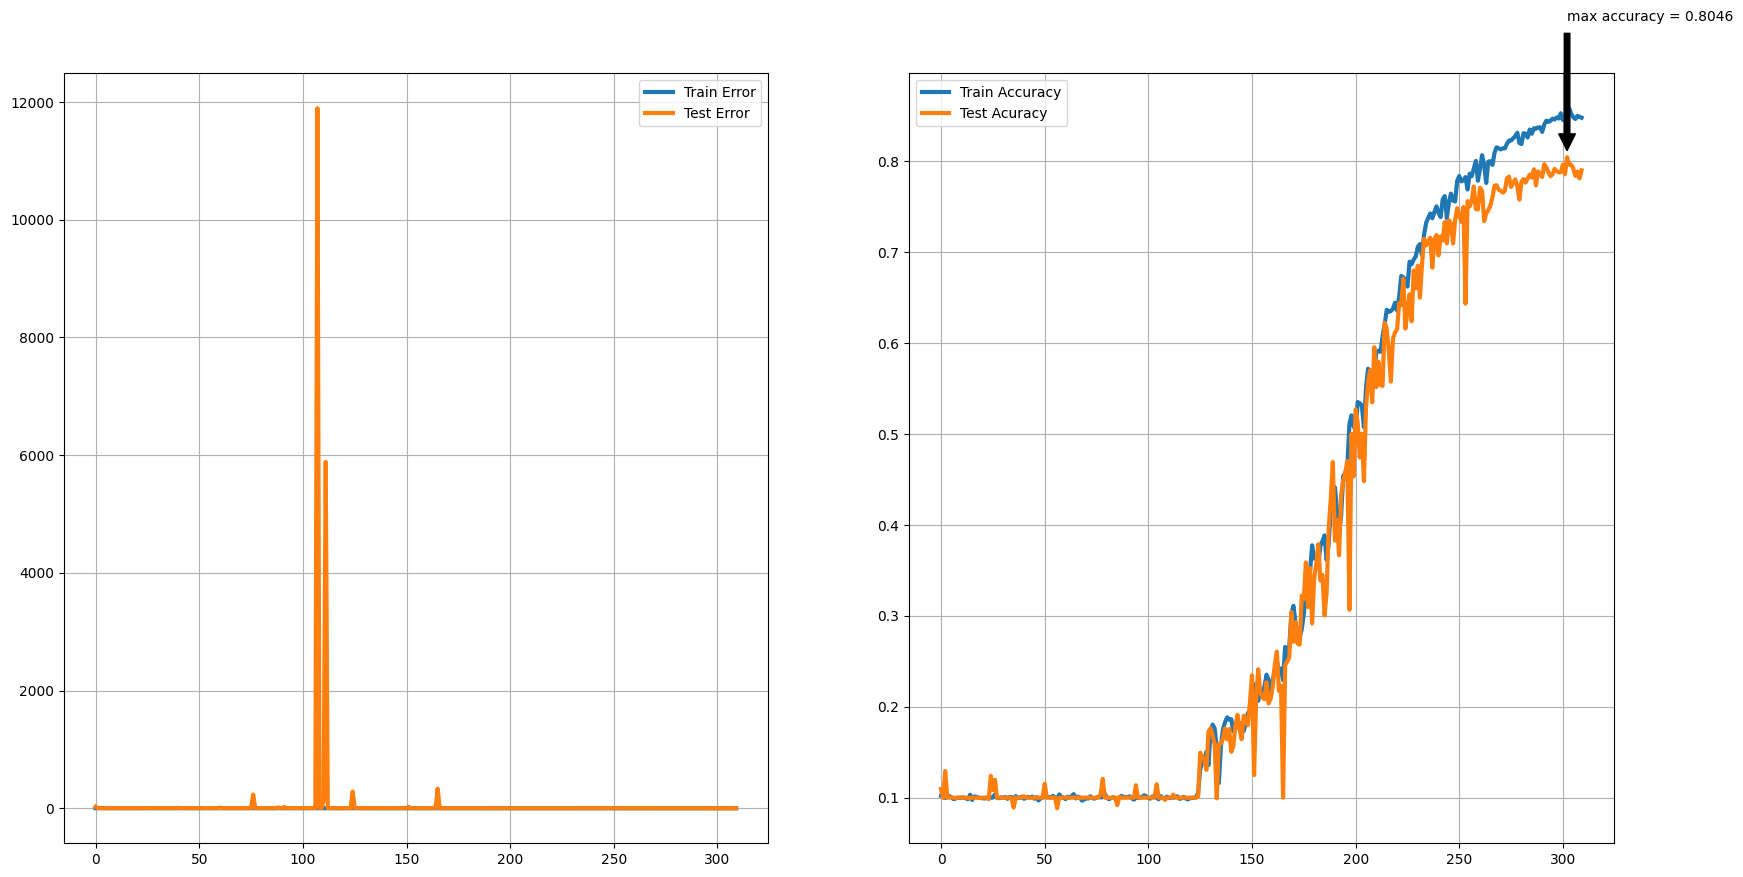

In [ ]:
# Create a figure object with two subplots, with a size of 20 by 10.
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))

# Set the number of data points in the training data to n.
n = len(train_loss)

# Plot the training loss and testing loss against the number of epochs on the first subplot.
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')

# Plot the training accuracy and testing accuracy against the number of epochs on the second subplot.
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')

# Annotate the maximum accuracy achieved with an arrow on the second subplot.
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))

# Turn on the grid lines for both subplots.
fig1.grid(True)
fig2.grid(True)

# Add legends to both subplots.
fig1.legend()
fig2.legend()

# Save the figure to a file named "trainTestCurve.png".
f.savefig("./trainTestCurve.png")

In [ ]:
torch.save(model.state_dict(), '/content/model2.pt')